# LightGBM pour le texte

LightGBM est un framework de gradient boosting qui utilise des algorithmes basés sur les arbres de décisions. Il a été conçu pour être distribué et efficace.  
  
Il possède les avantages suivants:  
  * Rapidité de l'entrainement
  * Faible usage de la mémoire
  * Meilleur précision
  * Support du parallélisme, de la distribution et d el'usage de GPU
  
Pour plus de détails voir [ici](https://lightgbm.readthedocs.io/en/latest/index.html).



In [11]:
import numpy as np
import pandas as pd
from time import time

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
import pickle
import time
import html
import os
import re

import spacy
import nltk
from nltk.corpus import stopwords

from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import f1_score, make_scorer, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier,NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from lightgbm import LGBMClassifier


def f1_score_w(y_true, y_pred, **kwargs):
    return f1_score(y_true, y_pred, average='weighted')

def read_embed_split(embed, nb=NB_ECHANTILLONS):
    """
    Lecture et train/test split

    """
    X = pd.read_csv("X_train_update.csv").drop("Unnamed: 0", axis=1)[:nb]
    X['description'].fillna(X['designation'], inplace=True)
    X = X.apply(lambda r: r['designation'] + ' ' + r['description'], axis=1)
    y = pd.read_csv("Y_train_CVw08PX.csv")[:nb].drop("Unnamed: 0", axis=1)["prdtypecode"]
    X, y = shuffle(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=51)
    X_train = np.array([embed(X_train[x]) for x in X_train.index]).reshape(X_train.shape[0],-1)
    X_test = np.array([embed(X_test[x]) for x in X_test.index]).reshape(X_test.shape[0],-1)
    return X_train, X_test, y_train, y_test

def read_X(X_file):
    """
    Lecture d'un fichier de données (dataframe) X et petit nettoyage

    """
    df = pd.read_csv(X_file)
    # La première colonne est un doublon:
    #          df["Unnamed: 0"] == df.index 
    df = df.drop("Unnamed: 0", axis=1)
    # Les colonnes designation et description sont à l'origine de type objet
    #          df.info()
    df.designation = df.designation.astype('string')
    df.description = df.description.astype('string')
    return df


def remove_accents(text):
    """
    Supprime les accents du texte <text>
    """
    accents = { 'a': ['à', 'ã', 'á', 'â'],
                'e': ['é', 'è', 'ê', 'ë'],
                'i': ['î', 'ï'],
                'u': ['ù', 'ü', 'û'],
                'o': ['ô', 'ö'] }
    for ch in accents:
        for chacc in accents[ch]:
            text = text.replace(chacc, ch)
    return text


#reclean = re.compile(r"(\<.*?\>|\&\#\d+\;)")
def X_text(X):
    """
    A partir d'un dataframe X retourne une liste de textes (un par échantillon
    du dataframe X)
    """
    lst = []
    for desc, desi in zip(X.description, X.designation):
        descstr = desc if type(desc) == str else ''
        desistr = desi if type(desi) == str else ''
        sep = ' ' if type(desc) == str and type(desi) == str else ''
        s = descstr + sep + desistr
        #s = reclean.sub(' ', s)
        #s = html.unescape(s)
        #s = re.sub(r"(\<)", " \1",s)
        #s = re.sub(r"(\>)", "\1 ",s)
        s = s.lower() + ' ' + re.sub(r"([^A-Z0-9°\+\*\=]+)","",s).lower()
        lst.append(s)
    return lst


spacynlp = None
spacyre = re.compile(r"(<.*?>|&#\d+;|\'|\:|\.|\-|\+)")
french_stop_words = set(stopwords.words('french'))
french_stop_words_no_accent = [remove_accents(x) for x in french_stop_words]
def tokenize_spacy(sentence):
    """
    Tokenizer basé sur spacy
    """
    global spacynlp
    if spacynlp is None:
        spacynlp = spacy.load("fr_core_news_sm")
        spacynlp.disable_pipes ('tagger', 'parser', 'ner')
    s = sentence
    t = [x.lemma_ for x in spacynlp(s)]
    #t = [x.text for x in spacynlp(s) if not x.text in french_stop_words]
    return t


def evaluate_model(name, model, X_trn, X_tst, y_trn, y_tst):
    """
    Entraine un modèle <model> nommé <name> et affiche son score
    """
    start = time.time()
    model.fit(X_trn, y_trn)
    y_pred = model.predict(X_tst)
    stop = time.time()
    score = f1_score_w(y_tst, y_pred)
    print(f"{name:<15} weighted-F1-score = {round(score,5)} ({round(stop-start,2)}s)")
    return model


def evaluate_tfclf_step_by_step(name, clf):
    """
    Entraine le model <clf> nommé <name> avec des tailles croissantes d'échantillons
    et affiche une synthèse à la fin
    """
    def display_progress(df, nb):
        r = df.loc[nb]
        print(f"nb={nb} w-f1-score={r.score} ({int(r.vocalen)} mots, {r.time} sec)")
    
    X0 = read_X("X_train_update.csv")
    y0 = pd.read_csv("Y_train_CVw08PX.csv").drop("Unnamed: 0", axis=1)["prdtypecode"]
    test_size = 0.20
    X, y = shuffle(X_text(X0), y0, random_state=51)
    filename = name + ".pkl"
    if os.path.isfile(filename):
        df = pd.read_pickle(filename)
    else:
        df = pd.DataFrame({'nb':[], 'score':[], 'vocalen':[], 'time': []})

    for nb in range(4000, len(X), 8000):
        if nb in df.index:
            display_progress(df, nb)
            continue
        X_trn, X_tst, y_trn, y_tst = train_test_split(X[:nb], y[:nb], shuffle=True, random_state=51)
        now = datetime.datetime.now().strftime("%Hh%Mmn")
        print(f"... Evaluation avec {nb} échantillons ({now}) ...")
        start = time.time()
        clf.fit(X_trn, y_trn)
        y_pred = clf.predict(X_tst)
        vocalen = len(clf[0].vocabulary_)
        stop = time.time()
        delta = round(stop-start,2)
        score = round(f1_score_w(y_tst, y_pred), 5)
        df.loc[nb] = [nb, score, vocalen, delta]
        display_progress(df, nb)
        df.to_pickle(filename)    

    # Affichage
    filename = name + ".pkl"
    if not os.path.isfile(filename):
        print(f"File {filename} not found!")
        return
    df = pd.read_pickle(filename)
    plt.figure(figsize=(12,4))
    ax1 = plt.subplot(1,1,1)
    ibest = df.score.sort_values().index[-1:]
    bestnb = np.float(df.nb[ibest])
    bestscore = np.float(df.score[ibest])
    plt.plot(df.nb, df.score,c='b', label='weighted F1 score')
    plt.plot(np.array([0, bestnb, bestnb], dtype=object),
             np.array([bestscore, bestscore, 0], dtype=object))
    plt.title(f"Score = {bestscore} pour {int(bestnb)} échantillons")
    plt.xlim(4000, df.nb.max() + 1000)
    plt.ylim(0.5, 1)
    plt.xlabel("Nombre d'échantillons")
    plt.ylabel("Score")
    plt.legend()
    plt.show()


In [12]:
#
# Essais sur les données textes passées  préalablement par une étape d'embedding
# On compare avec d'autes classifiers
#
NB_ECHANTILLONS = 60000

import tensorflow_text
import tensorflow_hub as hub

#embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3")
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3")
#embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-xling/en-fr/1")

t0 = time()
X_train, X_test, y_train, y_test = read_embed_split(embed)
tembed = int(time() - t0)
print(f"Embedding de {NB_ECHANTILLONS} échantillons ({tembed} sec)")

clfs = {"RandomForestClassifier": RandomForestClassifier(),
        "KNeighborsClassifier": KNeighborsClassifier(),
        "LinearSVC": LinearSVC(),
        "LightGBM" : LGBMClassifier(n_estimators=150, learning_rate=0.07,
                     boosting_type='gbdt', class_weight='balanced')
       }
for clfname in clfs:
    clf = clfs[clfname]
    t0 = time()
    clf.fit(X_train, y_train)
    tfit = int(time() - t0)
    y_pred = clf.predict(X_test)
    score = round(f1_score_w(y_test, y_pred), 4)
    print(f"{clfname} ({NB_ECHANTILLONS} échantillons) w-f1-score = {score} ({tfit} sec)")

    
# LightGBM    
#20000 Default = n_estimators = 100 learning_rate = 0.1 boosting_type='gbdt' => 0.7316
#20000 Default = n_estimators = 150 learning_rate = 0.07 boosting_type='gbdt' => 0.7471
#20000 Default = n_estimators = 200 learning_rate = 0.05 boosting_type='gbdt' => 0.7427 (164s)
#20000 Default = n_estimators = 150 learning_rate = 0.07 boosting_type='dart'=> 0.725 (125s)
#20000 Default = n_estimators = 150 learning_rate = 0.07 boosting_type='gbdt'class_weight='balanced'=> 0.7549 (131s)


Embedding de 60000 échantillons (5537 sec)
RandomForestClassifier (60000 échantillons) w-f1-score = 0.7126 (152 sec)
KNeighborsClassifier (60000 échantillons) w-f1-score = 0.7701 (0 sec)
LinearSVC (60000 échantillons) w-f1-score = 0.7669 (21 sec)
LightGBM (60000 échantillons) w-f1-score = 0.767 (231 sec)


... Evaluation avec 4000 échantillons (14h19mn) ...
nb=4000 w-f1-score=0.63501 (38828 mots, 45.85 sec)
... Evaluation avec 12000 échantillons (14h19mn) ...
nb=12000 w-f1-score=0.71611 (97274 mots, 199.35 sec)
... Evaluation avec 20000 échantillons (14h23mn) ...
nb=20000 w-f1-score=0.75769 (147041 mots, 400.6 sec)
... Evaluation avec 28000 échantillons (14h29mn) ...
nb=28000 w-f1-score=0.78722 (193450 mots, 603.83 sec)
... Evaluation avec 36000 échantillons (14h39mn) ...
nb=36000 w-f1-score=0.79452 (238859 mots, 827.46 sec)
... Evaluation avec 44000 échantillons (14h53mn) ...
nb=44000 w-f1-score=0.80752 (279268 mots, 1027.37 sec)
... Evaluation avec 52000 échantillons (15h10mn) ...
nb=52000 w-f1-score=0.81719 (317898 mots, 1207.77 sec)
... Evaluation avec 60000 échantillons (15h31mn) ...
nb=60000 w-f1-score=0.82389 (355611 mots, 1415.97 sec)
... Evaluation avec 68000 échantillons (15h54mn) ...
nb=68000 w-f1-score=0.82682 (394333 mots, 1664.67 sec)
... Evaluation avec 76000 échantillons 

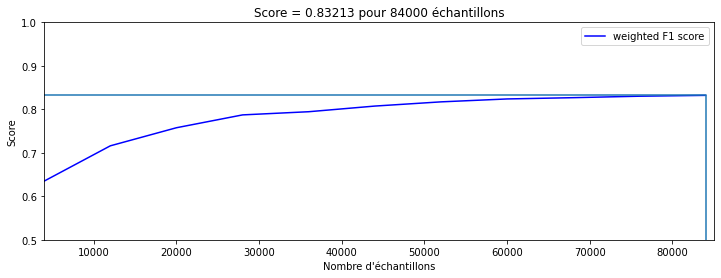

In [15]:
#
# Essais en passant par une vectorisation classique data mining TfidfVectorizer
# Résultat interessant, comparables au meilleurs algorithmes essayés jusqu'à
# présent (le meilleur étant linearSVC avec f1-w = 0.85)
#

Nb_ECHANTILLONS = 10000
clf_lgbm = make_pipeline(
    TfidfVectorizer(analyzer='word',
                  tokenizer=tokenize_spacy,
                      #strip_accents='unicode',
                      #stop_words=french_stop_words_no_accent, # peut etre interessant parce que lisse la progression
                  max_df=0.8,
                  min_df=2,
                  ngram_range=(1,2),
                  use_idf=True,
                  smooth_idf=True,
                  sublinear_tf=False,
                  binary=True,
                  ),
    LGBMClassifier(n_estimators=150, learning_rate=0.07,
                     boosting_type='gbdt', class_weight='balanced')
)
evaluate_tfclf_step_by_step("clf_lgbm_learning", clf_lgbm)